# Entrenamiento de la Red Neuronal Recurrente 
En este notebook se muestra el entrenamiento de la red neuronal recurrente Long Short Term Memmory (LSTM), usando el dataset de 1.6 millones de tweets "sentiment 140". 

Una vez es entrenada la red neuronal, se guarda el modelo y sus pesos para ser usados en el programa principal.

In [15]:
import os
import dask
import keras
import numpy as np
from IPython.display import Image
from string import punctuation

## Leer el conjunto de datos (entrenamiento y prueba)
El conjunto de datos es un archivo con formato .csv que consiste de las siguientes columnas:

0. Target (0=negativo, 2=neutro, 4=positivo) 
1. ID del tweet
2. Fecha de publicación del tweet
3. Query
4. Usuario que publicó
5. Texto del tweet

El tamaño de los conjuntos es el siguiente:

    Entrenamiento = 700,000 tweets
    Prueba = 300,000 tweets

In [18]:
# Leer el conjunto de datos (1.6M tweets)
data_frame = dask.dataframe.read_csv('trainingandtestdata/training.1600000.processed.noemoticon.csv', 
                       sep=',', header=0, usecols=[0, 5], names=['Target', 'Tweet'], encoding='latin-1')

In [19]:
data_frame.head()

Target                                              Tweet
0       0  is upset that he can't update his Facebook by ...
1       0  @Kenichan I dived many times for the ball. Man...
2       0    my whole body feels itchy and like its on fire 
3       0  @nationwideclass no, it's not behaving at all....
4       0                      @Kwesidei not the whole crew

In [1]:
# Crear una lista para los tweets y los targets
data_tweets = list(data_frame['Tweet'].to_bag(index=False))[700000:1000000]
data_targets = list(data_frame['Target'].to_bag(index=False))[700000:1000000]

In [7]:
# Barajar aleatoriamente el conjunto de datos
data_set = [[value, target] for value, target in zip(data_tweets, data_targets)]
np.random.shuffle(data_set)

In [8]:
data_set[:3]

[['@GreyEyes No FF for me this week as Im only working half day and no iron  and, Timeonline is due by noon today (Sat shift is on this pay)',
  0],
 ['Im having one lonely night ', 0],
 ["@Twiter_ME_This you aren't a baseball fan??  Too bad. Its a great way to enjoy the wonderful spring weather. ",
  4]]

In [9]:
# En el dataset originalmente se asigna a un sentimiento positivo el numero 4,
# por simplicidad, se cambiara ese numero 4 por un 1.
for i in range(len(data_set)):
    if data_set[i][1] == 4:
        data_set[i][1] = 1

In [10]:
data_set[:3]

[['@GreyEyes No FF for me this week as Im only working half day and no iron  and, Timeonline is due by noon today (Sat shift is on this pay)',
  0],
 ['Im having one lonely night ', 0],
 ["@Twiter_ME_This you aren't a baseball fan??  Too bad. Its a great way to enjoy the wonderful spring weather. ",
  1]]

In [11]:
# Formar los conjuntos de entrenamiento y prueba
x_training = [data_set[i][0] for i in range(len(data_set))][:700000]
y_training = [data_set[i][1] for i in range(len(data_set))][:700000]

x_test = [data_set[i][0] for i in range(len(data_set))][700000:1000000]
y_test = [data_set[i][1] for i in range(len(data_set))][700000:1000000]

## Preprocesamiento de los datos
Para poder entrenar la red neuronal recurrente, necesitamos que el texto de los tweets sea preprocesado realizando los siguientes pasos:

1. Tokenizacion: Remover caracteres especiales, espacios, mayusculas y asignar un numero entero a cda palabra
2. Word embedding: Convertir a una representacion vectorial las palabras previamente tokenizadas.

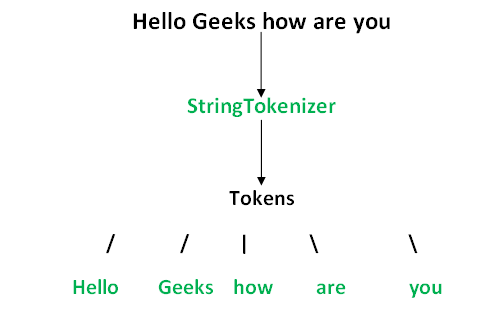

In [5]:
Image(filename='imgs/StringTokenizer.png', height=300, width=400)

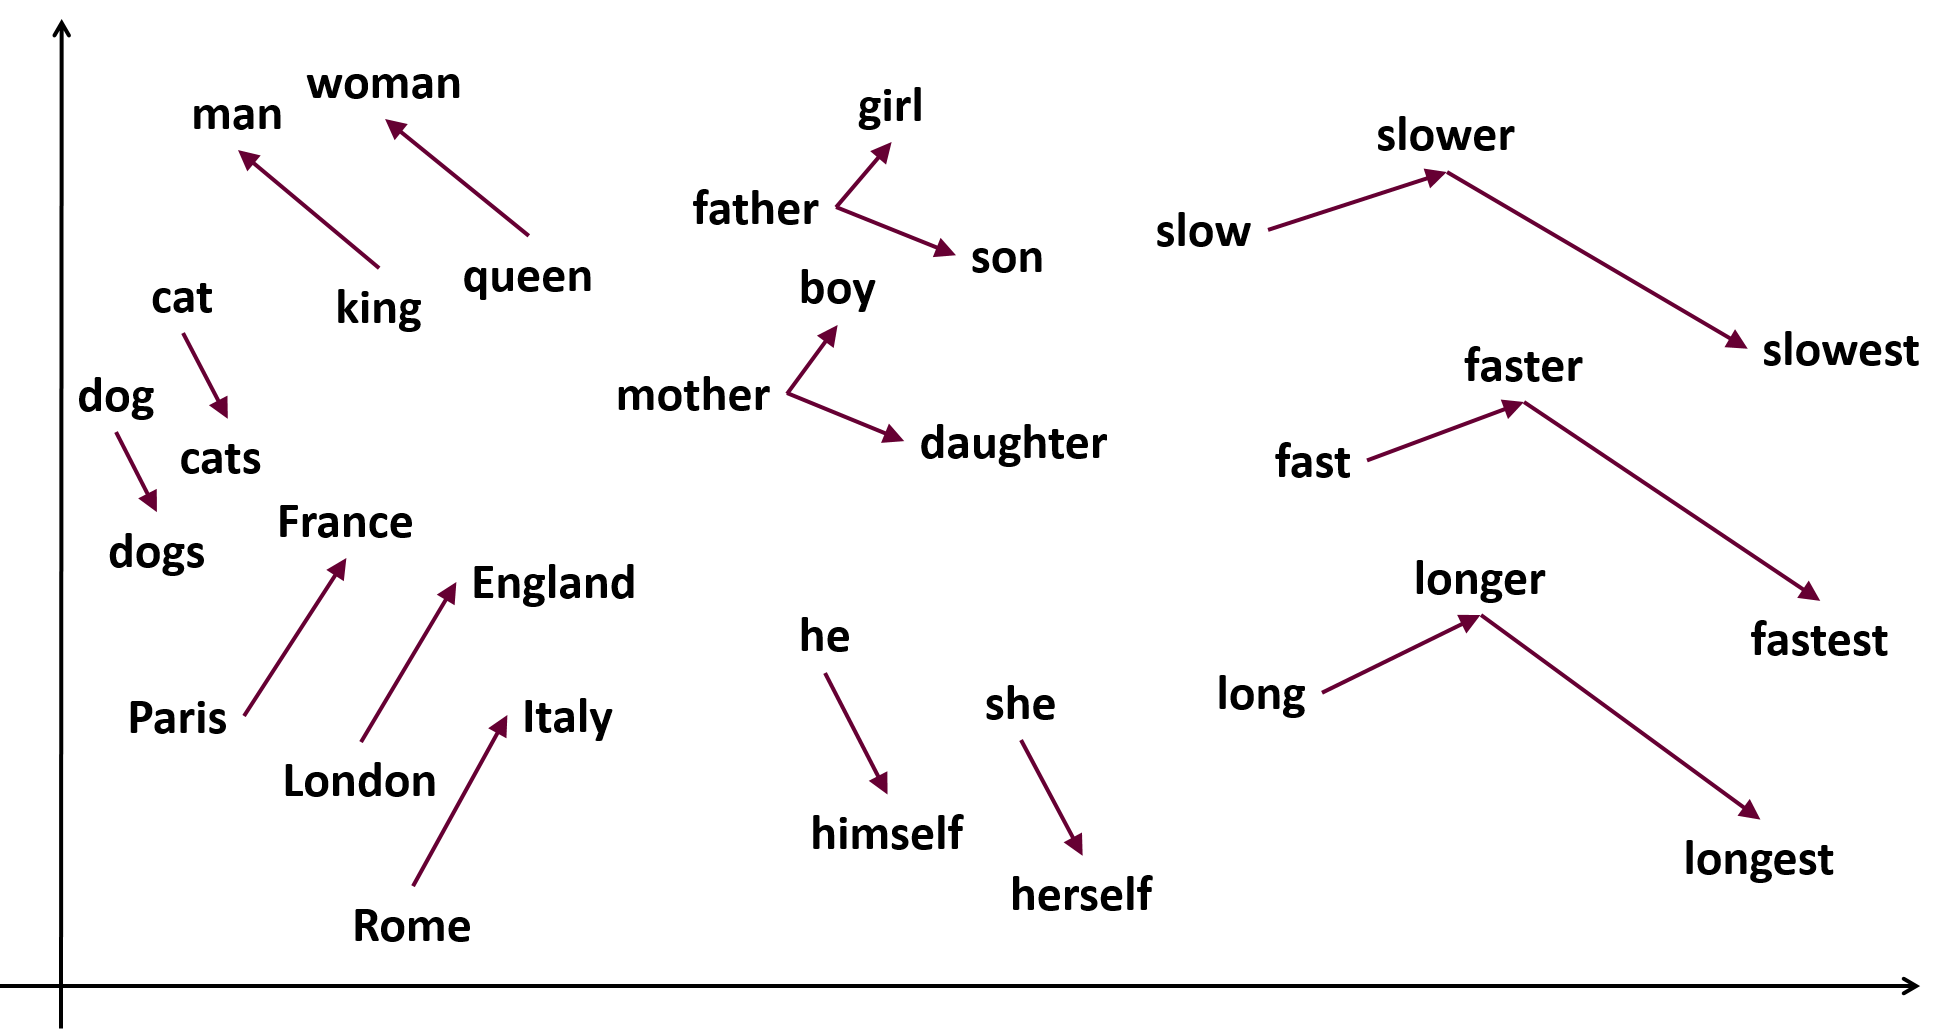

In [9]:
Image(filename='imgs/word2vec2.png', height=300, width=400)

In [12]:
# Objeto tokenizer con un limite de 10000 palabras del data-set
num_words = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = num_words)

In [13]:
# Aplicar el tokenizer a los datos de entrenamiento 
tokenizer.fit_on_texts(x_training)

In [14]:
# El indice representa la palabra mas usada en orden ascendente
x_training_tokens = tokenizer.texts_to_sequences(x_training)
x_test_tokens = tokenizer.texts_to_sequences(x_test)
tokenizer.word_index

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'is': 8,
 'it': 9,
 'in': 10,
 'for': 11,
 'of': 12,
 'on': 13,
 'me': 14,
 'so': 15,
 'have': 16,
 'that': 17,
 'but': 18,
 "i'm": 19,
 'just': 20,
 'with': 21,
 'be': 22,
 'at': 23,
 'not': 24,
 'was': 25,
 'this': 26,
 'now': 27,
 'up': 28,
 'good': 29,
 'day': 30,
 'out': 31,
 'get': 32,
 'all': 33,
 'like': 34,
 'are': 35,
 'no': 36,
 'go': 37,
 'http': 38,
 'quot': 39,
 'do': 40,
 'today': 41,
 'too': 42,
 "it's": 43,
 'love': 44,
 'your': 45,
 'going': 46,
 'work': 47,
 'got': 48,
 'lol': 49,
 'time': 50,
 'back': 51,
 'from': 52,
 'u': 53,
 'one': 54,
 'what': 55,
 'com': 56,
 'im': 57,
 'will': 58,
 'know': 59,
 'we': 60,
 'am': 61,
 'about': 62,
 'really': 63,
 "don't": 64,
 'amp': 65,
 'had': 66,
 'can': 67,
 'see': 68,
 'some': 69,
 "can't": 70,
 'its': 71,
 'if': 72,
 'still': 73,
 'well': 74,
 '2': 75,
 'night': 76,
 'how': 77,
 'want': 78,
 'new': 79,
 'think': 80,
 'thanks': 81,
 'home': 82,
 'oh': 

In [15]:
# Representacion usando caracteres
x_training[0]

'@GreyEyes No FF for me this week as Im only working half day and no iron  and, Timeonline is due by noon today (Sat shift is on this pay)'

In [16]:
np.array(x_training_tokens[0])

array([  36,  925,   11,   14,   26,  146,   86,   57,  115,  177,  467,
         30,    6,   36, 3096,    6,    8,  808,  126, 2564,   41,  805,
       1490,    8,   13,   26,  587])

In [17]:
# Contar el numero de tokens en total
num_tokens = np.array([len(token) for token in x_training_tokens])
len(num_tokens)

700000

In [18]:
print('Numero de tokens en promedio = %s' % np.mean(num_tokens))
print('Maximo numero de tokens = %s' % np.max(num_tokens))

Numero de tokens en promedio = 12.257317142857143
Maximo numero de tokens = 50


In [19]:
max_tokens = int(np.mean(num_tokens) + 2*np.std(num_tokens))
print('Numero de tokens limite por tweet = %s' % max_tokens)


Numero de tokens limite por tweet = 25


In [20]:
# Porcentaje de datos que se toman en cuenta al seleccionar como longitud limite 25 tokens
np.sum(num_tokens<max_tokens) / len(num_tokens)

0.95268

In [21]:
# Realizar el zero padding o truncamiento de los tokens del dataset
x_training_pad = keras.preprocessing.sequence.pad_sequences(x_training_tokens, maxlen=max_tokens,
                                                           padding='pre', truncating='pre')

x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_tokens, maxlen=max_tokens,
                                                           padding='pre', truncating='pre')

### Creacion de la red neuronal recurrente

La red neuronal que se usará para clasificar los tweets como positivos o negativos es una del tipo recurrente, y más especificamente una Memoria Larga a Corto Plazo (LSTM). A la salida de la LSTM se agrega una capa fully conected con activación sigmoide.

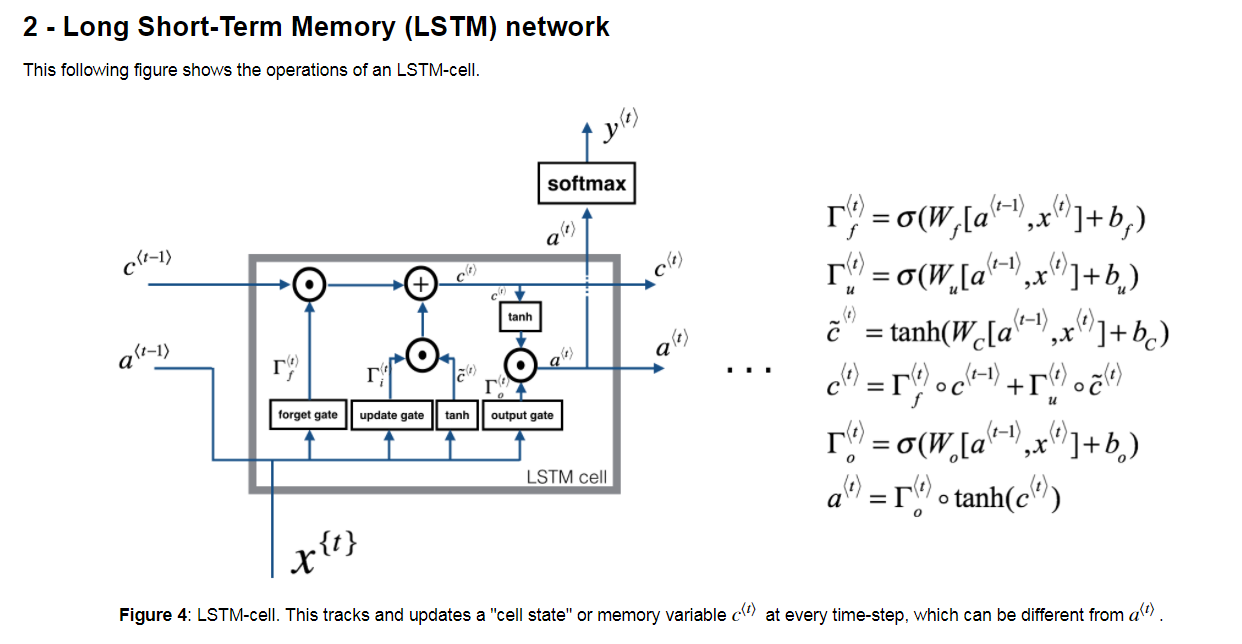

In [14]:
Image(filename='imgs/lstm.png', height=800, width=900)

In [39]:
rnn = keras.models.Sequential()

In [40]:
embed_dim = 64
lstm_out = 100

In [41]:
# Capa Embedding 
rnn.add(keras.layers.Embedding(input_dim=num_words, 
                               output_dim=embed_dim, 
                               input_length=max_tokens,
                               name='embedding_layer'))

In [42]:
rnn.add(keras.layers.LSTM(lstm_out))

In [43]:
rnn.add(keras.layers.Dense(1, activation='sigmoid'))

In [44]:
rnn.compile(loss='binary_crossentropy', 
            optimizer='adam',
            metrics=['accuracy'])

In [45]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 25, 64)            640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 706,101
Trainable params: 706,101
Non-trainable params: 0
_________________________________________________________________


In [47]:
%%time
rnn.fit(x_training_pad, y_training, validation_split=0.05, epochs=20, batch_size=1024)

Train on 665000 samples, validate on 35000 samples
Epoch 1/20
665000/665000 [==============================] - 232s 349us/step - loss: 0.4418 - acc: 0.7959 - val_loss: 0.4234 - val_acc: 0.8035
Epoch 2/20
665000/665000 [==============================] - 222s 333us/step - loss: 0.4068 - acc: 0.8130 - val_loss: 0.4069 - val_acc: 0.8127
Epoch 3/20
665000/665000 [==============================] - 213s 320us/step - loss: 0.3893 - acc: 0.8226 - val_loss: 0.4019 - val_acc: 0.8155
Epoch 4/20
665000/665000 [==============================] - 213s 321us/step - loss: 0.3773 - acc: 0.8289 - val_loss: 0.4039 - val_acc: 0.8175
Epoch 5/20
665000/665000 [==============================] - 214s 322us/step - loss: 0.3668 - acc: 0.8341 - val_loss: 0.4046 - val_acc: 0.8142
Epoch 6/20
665000/665000 [==============================] - 214s 322us/step - loss: 0.3572 - acc: 0.8388 - val_loss: 0.4076 - val_acc: 0.8139
Epoch 7/20
665000/665000 [==============================] - 241s 363us/step - loss: 0.3475 - acc:

In [48]:
score, acc = rnn.evaluate(x_test_pad, y_test, batch_size=128)

300000/300000 [==============================] - 30s 102us/step


In [49]:
print('score = ', score)
print('accuracy = ', acc)

score =  0.7392415662829082
accuracy =  0.7920200000063579


In [54]:
if not os.path.exists("/model"):
    os.makedirs("model")

In [58]:
rnn.save('model/model.h5')
rnn.save_weights('model/weights.h5')

In [16]:
rnn = keras.models.load_model('model/model.h5')